In [1]:
%matplotlib inline
from ecell4 import *
from scipy.optimize import curve_fit
import scipy
import numpy as np
import math
import matplotlib.pylab as plt
rng = core.GSLRandomNumberGenerator()

In [2]:
def expfunc(k, N):
    def func(x):
        return N * np.exp(-k * x)
    return func

In [3]:
def create_model(k, D, radius=0.005):
    with species_attributes():
        A | B | {'D': str(D), 'radius': str(radius), 'location': 'X'}
    with reaction_rules():
        A + B > B | k # um^2/s
    return get_model()

In [4]:
def singlerun(k, D, voxel_radius, L, N,run):
    radius = voxel_radius
    NB = N
    rng.seed(run)
    m = create_model(k, D, radius)
    w = spatiocyte.SpatiocyteWorld(ones() * L, voxel_radius,rng)
    w.bind_to(m)
    w.add_structure(Species('X'), PlanarSurface(unitx() * L / 2, unity() * L, unitz() * L))
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), NB)
    sim = spatiocyte.SpatiocyteSimulator(w)
    obs = NumberObserver(['A'])
    while len(obs.data()) == 0 or obs.data()[-1][1] > N * 0.1:
        sim.run(0.1, obs)
    return obs

In [5]:
D = 1.
voxel_radius = 0.005#*2
L = 3.0
N = 240

In [11]:
ks = []
observers = []
params = []

for k in [10,100,1000]:
    alpha = (D + D) / (0.28986264423934294 * k)

    for i in range(3):
        obs = singlerun(k, D, voxel_radius, L, N,i)
        data = np.array(obs.data()).T
        tlen = 0#len(data[0])/2
        p, covar = curve_fit(lambda x, *args: expfunc(args[0], N)(x), data[0][tlen:], data[1][tlen:], p0=[k])
        ks.append(k)
        observers.append(obs)
        params.append(p[0])
        print(k, p[0], p[0] / k, alpha,covar)
        print 'keff by fitting',p[0]/(float(N)/L/L)

(10, 87.155663171650019, 8.7155663171650026, 0.6899819758590819, array([[ 0.24189386]]))
keff by fitting 3.26833736894
(10, 90.884548225179714, 9.0884548225179707, 0.6899819758590819, array([[ 0.43748585]]))
keff by fitting 3.40817055844
(10, 94.656535635381431, 9.4656535635381438, 0.6899819758590819, array([[ 0.57902107]]))
keff by fitting 3.54962008633
(100, 140.45134174120281, 1.4045134174120282, 0.06899819758590821, array([[ 3.70754285]]))
keff by fitting 5.2669253153
(100, 130.45448853962975, 1.3045448853962975, 0.06899819758590821, array([[ 3.13361081]]))
keff by fitting 4.89204332024
(100, 144.05439993614942, 1.4405439993614941, 0.06899819758590821, array([[ 3.3724766]]))
keff by fitting 5.40203999761
(1000, 158.73772783531732, 0.15873772783531731, 0.00689981975859082, array([[ 2.45982573]]))
keff by fitting 5.95266479382
(1000, 149.37167708318844, 0.14937167708318844, 0.00689981975859082, array([[ 1.12396205]]))
keff by fitting 5.60143789062
(1000, 144.93012196191697, 0.1449301

In [ ]:
5.43487957357

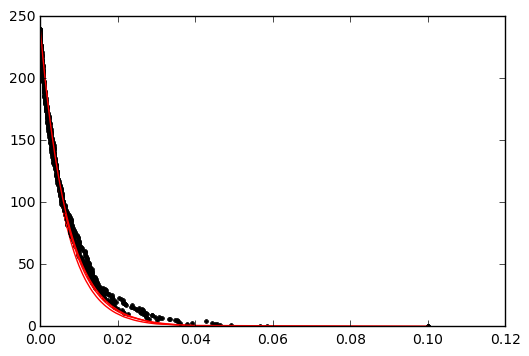

In [9]:
for i,obs in enumerate(observers):
    t,na = zip(*obs.data())
    plt.plot(t,na,'k.')
    plt.plot(t,[expfunc(params[i],N)(tt) for tt in t],'r-')
    #plt.xscale('log')
#viz.plot_number_observer(*observers, *[expfunc(p, N) for p in params], ylim=(N * 0.2, N), legend=False)

/home/chew/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


1.0 0.005 1.0 [  3.44869065e-07]
keff by fitting survival prob 0.869335650747


0.86933565074710173

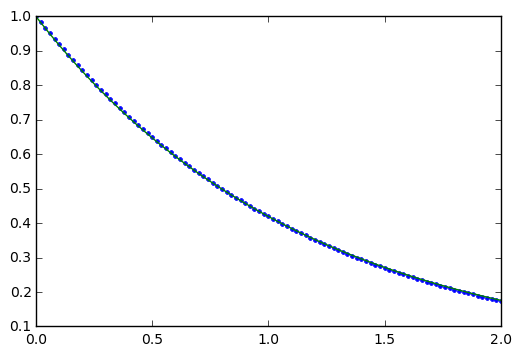

In [13]:
def test(k):
    gamma = 0.5772156649
    f = lambda x: k / (1 + k / 4 * np.pi * (D + D) / (np.log(4 * (D + D) * x / (voxel_radius * voxel_radius)) - 2 * gamma))
    x = np.linspace(0, 2, 101)
    y = [np.exp(-scipy.integrate.quad(f, 0, xi)[0]) for xi in x]
    p, covar = curve_fit(lambda x, *args: expfunc(args[0], 1.0)(x), x, y, p0=[1.0])
    plt.plot(x,y,'.')
    #plt.xscale('log')
    #plt.yscale('log')
    plt.plot(x,expfunc(p[0], 1.0)(x))
    print D,voxel_radius,k,covar[0]
    print 'keff by fitting survival prob', p[0]
    return p[0]
test(1.)